# Power distribution in legislative chamber based on districting plan.

My goal is to compare the power distribution in the Virginia house of delegates in 2017 to the one that would have resulted if redistricting has occurred that year using MCMC. 

## Creating sample data: Fairfax City and County

I want to do some exploratory redistricting, but I need to work with a smaller data set. I'm going to use the fantastic 2017 shapefiles that includes population data and election results from MGGG. 

In [20]:
library(sf)
library(ggplot2)
library(tidyverse)
library(tibble)
library(magrittr)

# read in file
data_dir = "C:/Users/madie/OneDrive/data/" # the data's on onedrive b/c the files are getting too large
df_va <- st_read(paste(data_dir, "VA-2017/VA_precincts/VA_precincts.shp", sep=""))

# separate out precincts in Fairfax County/city
df_ff <- df_va[df_va$locality %in% c("Fairfax County", "Fairfax City"),]

# add in unique ID for each precinct
df_ff <- cbind(geoid10 = rownames(df_ff), df_ff)

# save this small set of 249 precincts to a separate shape file.
st_write(df_ff, paste(data_dir, "VA-2017/Fairfax_precincts/Fairfax_precincts.shp", sep=""), append=FALSE)

Reading layer `VA_precincts' from data source `C:\Users\madie\OneDrive\data\VA-2017\VA_precincts\VA_precincts.shp' using driver `ESRI Shapefile'
Simple feature collection with 2439 features and 56 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -373531.2 ymin: 60026.37 xmax: 380257.5 ymax: 385298.6
projected CRS:  Lambert_Conformal_Conic
Deleting layer `Fairfax_precincts' using driver `ESRI Shapefile'
Writing layer `Fairfax_precincts' to data source `C:/Users/madie/OneDrive/data/VA-2017/Fairfax_precincts/Fairfax_precincts.shp' using driver `ESRI Shapefile'
Writing 249 features with 57 fields and geometry type Multi Polygon.


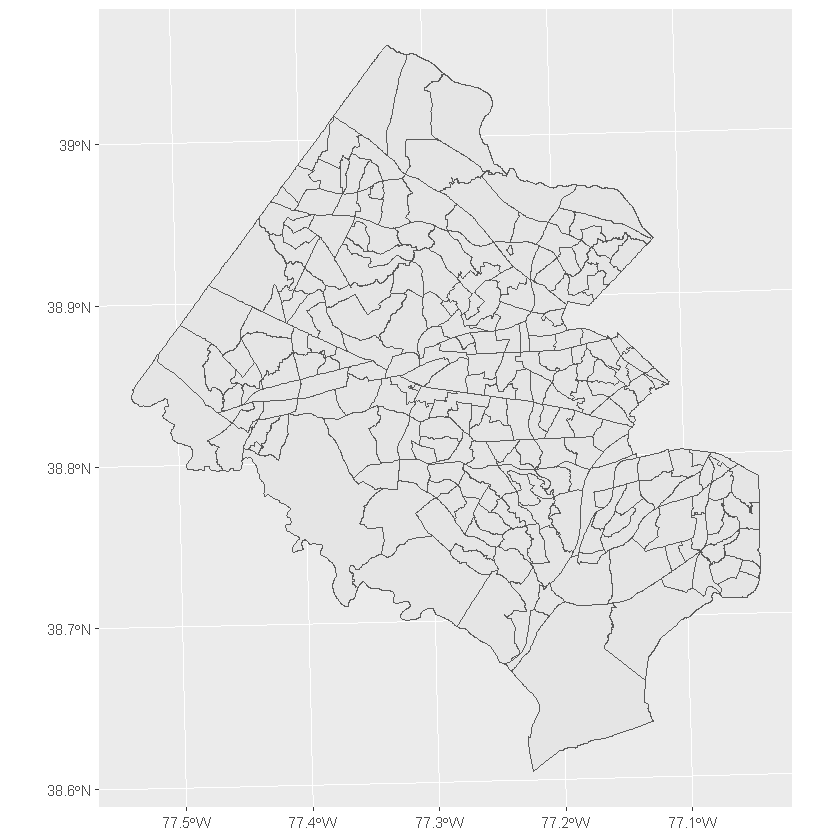

In [21]:
# plot the precincts!
ff_plot <- ggplot(data = df_ff) +
    geom_sf() #+
    #geom_sf_label(aes(label = geoid10))
ff_plot

## Reformat to meet MCMC requirements
MCMC has specific name requirements for cols, etc. I need to meet those. 

In [22]:
# copy over useful cols and rename them
df_ff <- df_ff %>%
    select(geoid10 = geoid10,
           pop = TOTPOP,
           vap = VAP,
           obama = G17DHOD,
           mccain = G17RHOD,
           TotPop = TOTPOP,
           BlackPop = NH_BLACK,
           HispPop = HISP,
           VAP_1 = VAP,
           BlackVAP = BVAP,
           HispVAP = HVAP,
           geometry = geometry)
# change all cols to numeric type
df_ff %<>% 
      mutate_each(funs(if(is.character(.)) as.numeric(.) else .))
head(df_ff)

,geoid10,pop,vap,obama,mccain,TotPop,BlackPop,HispPop,VAP_1,BlackVAP,HispVAP,geometry
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<MULTIPOLYGON [m]>
1,1580,1236,950,344,220,1236,35,57,950,24,41,MULTIPOLYGON (((201746.7 32...
2,1581,7218,6003,1451,0,7218,467,742,6003,367,573,MULTIPOLYGON (((199327.1 32...
3,1582,3016,2345,702,199,3016,63,1332,2345,42,988,MULTIPOLYGON (((201091.9 31...
4,1583,3395,2673,881,334,3395,201,930,2673,141,704,MULTIPOLYGON (((204934.1 31...
5,1584,3774,3050,761,372,3774,291,797,3050,218,582,MULTIPOLYGON (((199054.4 31...
6,1585,4239,3254,978,424,4239,481,769,3254,340,574,MULTIPOLYGON (((201483.1 31...


## Redistricting
Ok, now I can run through the fleet of redistricting methods enabled by `redist`.

In [23]:
library(redist)
library(sp)
library(spData)
library(spdep)
library(igraph)

### Adjacency-based Redistricting

Here each precinct gets a vector of the other precincts that it's adjacent to, and there's limited constraints applied. 

In [59]:
if (FALSE) {
    adjlist <- poly2nb(pl = precinct.data, queen = FALSE)
    # The C++ backend is more efficient if it's zero-indexed. 
    for(i in 1:249){
      adjlist[[i]] <- adjlist[[i]]-1
    }
}

adjlist <- redist.adjacency(df_ff)

### Single Chain

In [60]:
alg_mcmc <- redist.mcmc(adjobj = adjlist,
                        popvec = df_ff$pop,
                        ndists = 10,
                        nsims = 10000)


redist.mcmc(): Automated Redistricting Simulation Using
         Markov Chain Monte Carlo

Preprocessing data.


Using redist.rsg() to generate starting values.

10 percent done.
Metropolis acceptance ratio: 0.961962

20 percent done.
Metropolis acceptance ratio: 0.957979

30 percent done.
Metropolis acceptance ratio: 0.955318

40 percent done.
Metropolis acceptance ratio: 0.95899

50 percent done.
Metropolis acceptance ratio: 0.958392

60 percent done.
Metropolis acceptance ratio: 0.95966

70 percent done.
Metropolis acceptance ratio: 0.959851

80 percent done.
Metropolis acceptance ratio: 0.95887

90 percent done.
Metropolis acceptance ratio: 0.958884

100 percent done.
Metropolis acceptance ratio: 0.958196



I love smaller data sets! This took ~50 seconds to run, compared to about 100 min for the full 2500 precincts.

In [37]:
# generate 10 random colors that are distinct so that the different districts are distinguishable. 
library(randomcoloR)
colors <- distinctColorPalette(k=15)


Saving 6.67 x 6.67 in image



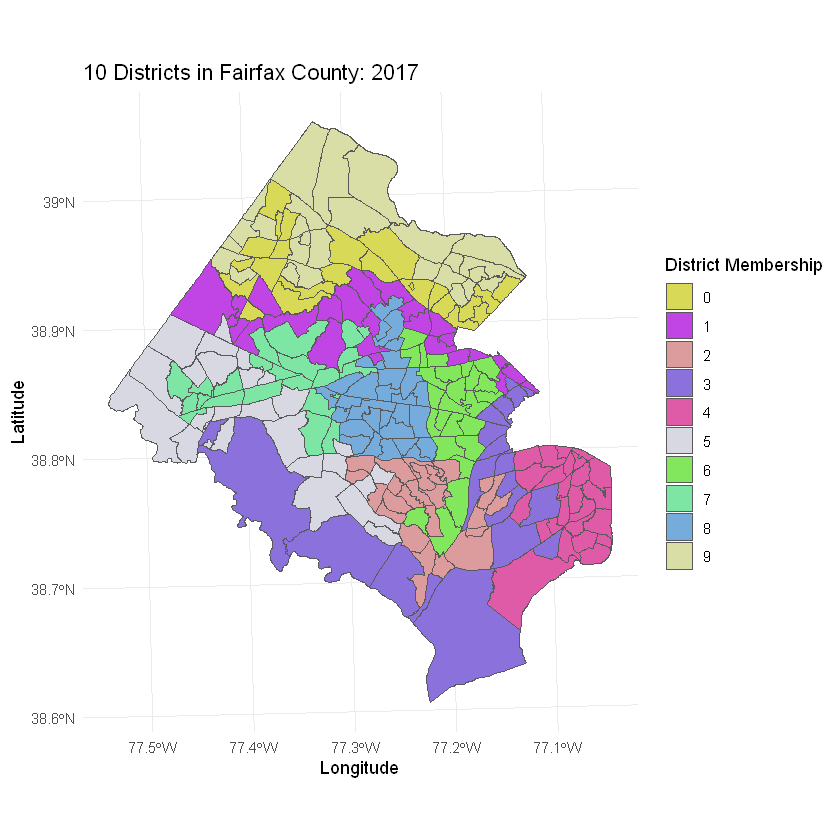

In [61]:
# Let's plot this!

cds <- alg_mcmc$partitions[,1]
plot <- redist.map(shp=df_ff, 
        district_membership=cds, 
        centroids=FALSE, 
        edges=FALSE,
        title="10 Districts in Fairfax County: 2017") +
        theme(legend.position="right") +
        scale_fill_manual(values = colors)
        # geom_sf_label(aes(label = cds))
ggsave("fairfax_10.png")
plot

### Gerrymandering metrics

The folks who worked on `redist` kindly included the ability to calculate all sorts of gerrymandering metrics. 

In [62]:
distances <- redist.distances(district_membership = alg_mcmc$partitions, ncores = 2)

In [63]:
distances$Hamming[,1:100]

0,1,2,3,4,5,6,7,8,9,...,62,63,64,63,63,64,65,66,67,66
1,0,1,2,3,4,5,6,7,8,...,61,62,63,62,62,63,64,65,66,65
2,1,0,1,2,3,4,5,6,7,...,60,61,62,61,61,62,63,64,65,64
3,2,1,0,1,2,3,4,5,6,...,59,60,61,60,60,61,62,63,64,63
4,3,2,1,0,1,2,3,4,5,...,58,59,60,59,59,60,61,62,63,62
5,4,3,2,1,0,1,2,3,4,...,57,58,59,58,58,59,60,61,62,61
6,5,4,3,2,1,0,1,2,3,...,56,57,58,57,57,58,59,60,61,60
7,6,5,4,3,2,1,0,1,2,...,57,58,59,58,58,59,60,61,62,61
8,7,6,5,4,3,2,1,0,1,...,56,57,58,57,57,58,59,60,61,60
9,8,7,6,5,4,3,2,1,0,...,55,56,57,56,56,57,58,59,60,59
10,9,8,7,6,5,4,3,2,1,...,54,55,56,55,55,56,57,58,59,58


In [69]:
length(df_ff$mccain)

[1] 249

In [73]:
data("algdata.p10")
print(length(algdat.p10$precinct.data$repvote))
print(nrow(algdat.p10$cdmat[]))

Warning message in data("algdata.p10"):
"data set 'algdata.p10' not found"


[1] 25
[1] 25


That took abt 5 min to run, keep in mind.

In [75]:
dists <- distances$Hamming[1:249,1:100]
metrics <- redist.metrics(dists, measure = 'all', df_ff$mccain, dvote = df_ff$obama)
print(metrics)

# A tibble: 9,300 x 13
   districts DSeats   DVS EffGap EffGapEqPop TauGap MeanMedian  Bias BiasV
       <int>  <int> <dbl>  <dbl>       <dbl>  <dbl>      <dbl> <dbl> <dbl>
 1         0     90 1      0.213         NaN    NaN        NaN  -0.5  -0.5
 2         1     90 0.779  0.213         NaN    NaN        NaN  -0.5  -0.5
 3         2     90 0.725  0.213         NaN    NaN        NaN  -0.5  -0.5
 4         3     90 0.672  0.213         NaN    NaN        NaN  -0.5  -0.5
 5         4     90 0.698  0.213         NaN    NaN        NaN  -0.5  -0.5
 6         5     90 0.818  0.213         NaN    NaN        NaN  -0.5  -0.5
 7         6     90 0.776  0.213         NaN    NaN        NaN  -0.5  -0.5
 8         7     90 0.785  0.213         NaN    NaN        NaN  -0.5  -0.5
 9         8     90 0.694  0.213         NaN    NaN        NaN  -0.5  -0.5
10         9     90 1      0.213         NaN    NaN        NaN  -0.5  -0.5
# ... with 9,290 more rows, and 4 more variables: Declination <dbl>,
#   Resp

In [79]:
# partisan symmetry??
ff_ddi <- redist.segcalc(alg_mcmc,
                         df_ff$mccain,
                         df_ff$pop)
ff_ddi

[1] 0.2126974 0.2086973 0.2055435 0.1991169 0.1991169 0.2077050 0.2077050
    [8] 0.2077050 0.2041566 0.1997114 0.1997114 0.1972888 0.1992033 0.1972888
   [15] 0.1927968 0.1927968 0.1953690 0.1953690 0.1982953 0.1982953 0.1982953
   [22] 0.1953009 0.2042885 0.2052580 0.1993657 0.1993657 0.1993657 0.1955179
   [29] 0.1953714 0.1953714 0.2069983 0.2069983 0.2025063 0.2025063 0.1960476
   [36] 0.2007373 0.2007373 0.2007373 0.2007373 0.1933154 0.1969225 0.1969225
   [43] 0.1965008 0.2010262 0.2010262 0.2010262 0.2010262 0.2010262 0.2010262
   [50] 0.1961989 0.1961989 0.2051865 0.2027516 0.2027516 0.2027516 0.1974296
   [57] 0.1974296 0.1933819 0.1933819 0.1933819 0.1933819 0.1888565 0.1834963
   [64] 0.1805729 0.1881586 0.1881586 0.1828050 0.1828050 0.1895493 0.1895493
   [71] 0.1895493 0.1925404 0.2009807 0.2040014 0.2080798 0.1996395 0.2043321
   [78] 0.2043321 0.2043321 0.2141609 0.2020035 0.2057257 0.2057257 0.2088197
   [85] 0.2088197 0.2154182 0.2263018 0.2232078 0.2232078 0.2232078 0.2118348
   [92] 0.2118348 0.2118348 0.2052362 0.2052362 0.2052362 0.2178941 0.2118658
   [99] 0.2184935 0.2267312 0.2267312 0.2237400 0.2301987 0.2321367 0.2321367
  [106] 0.2382218 0.2396423 0.2458619 0.2429469 0.2398360 0.2398360 0.2398360
  [113] 0.2351434 0.2351434 0.2411717 0.2411717 0.2442826 0.2442826 0.2442826
  [120] 0.2442826 0.2442826 0.2442826 0.2442826 0.2442826 0.2472738 0.2472738
  [127] 0.2346159 0.2389284 0.2330008 0.2446831 0.2469621 0.2469621 0.2469621
  [134] 0.2479000 0.2401974 0.2373348 0.2373348 0.2237688 0.2171411 0.2215863
  [141] 0.2215863 0.2215863 0.2215863 0.2215863 0.2161857 0.2126520 0.2192797
  [148] 0.2181800 0.2181800 0.2041925 0.2106191 0.2106191 0.2121970 0.2261845
  [155] 0.2215664 0.2215664 0.2215664 0.2215664 0.2215664 0.2215664 0.2215664
  [162] 0.2125788 0.2193326 0.2314899 0.2399302 0.2324245 0.2459905 0.2459905
  [169] 0.2459905 0.2573635 0.2489233 0.2459321 0.2459321 0.2323661 0.2323661
  [176] 0.2323661 0.2323661 0.2323661 0.2323661 0.2183785 0.2183785 0.2183785
  [183] 0.2183785 0.2183785 0.2183785 0.2160996 0.2160996 0.2160996 0.2205961
  [190] 0.2205961 0.2205961 0.2205961 0.2205961 0.2175024 0.2175024 0.2175024
  [197] 0.2107486 0.2142823 0.2142823 0.2142823 0.2114137 0.2158489 0.2158489
  [204] 0.2158489 0.2151456 0.2181368 0.2181368 0.2247794 0.2247794 0.2171414
  [211] 0.2171414 0.2171414 0.2208706 0.2208706 0.2221282 0.2242957 0.2242957
  [218] 0.2242957 0.2242957 0.2470696 0.2470696 0.2449021 0.2382595 0.2382595
  [225] 0.2509174 0.2509174 0.2509174 0.2509174 0.2509174 0.2509174 0.2509174
  [232] 0.2613811 0.2667483 0.2667483 0.2667483 0.2667483 0.2667483 0.2667483
  [239] 0.2667483 0.2553753 0.2553753 0.2553753 0.2553753 0.2553753 0.2553753
  [246] 0.2600679 0.2600679 0.2600679 0.2600679 0.2600679 0.2600679 0.2600679
  [253] 0.2600679 0.2600679 0.2600679 0.2600679 0.2600679 0.2570768 0.2523842
  [260] 0.2523842 0.2523842 0.2523842 0.2523842 0.2523842 0.2555428 0.2520091
  [267] 0.2292352 0.2292352 0.2292352 0.2292352 0.2292352 0.2227146 0.2117193
  [274] 0.2072566 0.2024293 0.2012553 0.2047204 0.2047204 0.2047204 0.2077072
  [281] 0.2032369 0.2057807 0.2109938 0.2109938 0.2077884 0.2097999 0.2097999
  [288] 0.2097999 0.2127150 0.2127150 0.2096509 0.2210239 0.2276516 0.2276516
  [295] 0.2276516 0.2223601 0.2223601 0.2223601 0.2223601 0.2225664 0.2225664
  [302] 0.2181699 0.2179636 0.2138250 0.2138250 0.2135232 0.2135232 0.2088745
  [309] 0.2088745 0.2096565 0.2064161 0.1999575 0.1999575 0.2013477 0.2058104
  [316] 0.2058104 0.2058104 0.2060769 0.2127591 0.2237543 0.2274106 0.2274106
  [323] 0.2220504 0.2220504 0.2086979 0.1982342 0.2021665 0.2071532 0.2071532
  [330] 0.2071532 0.2140465 0.2140465 0.2140465 0.2232960 0.2213791 0.2213791
  [337] 0.2163016 0.2123693 0.2188279 0.2074549 0.2074549 0.2106953 0.2106953
  [344] 0.2106953 0.2106953 0.2106953 0.2106953 0.2106953 0.2051842 0.2051842
  [351] 0.1999710 0.1999710 0.1972011 0.1985106 0.1972011 0.2001076 0.2001076
  [358] 0.1935091 0.196500

### SMC

More mucking about. 

In [82]:
alg_smc <- redist.smc(adjobj = adjlist,
                        popvec = df_ff$pop,
                        ndists = 10,
                        nsims = 10000)

Sampling 10000 249-unit maps with 10 districts and population tolerance 1%.
Making split 1 of 9
Using k=2 for estimated success probability of 26.68%


Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"

9693 valid samples (25.9% of total)
Making split 2 of 9
Using k=2 for estimated success probability of 20.75%


Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"

11183 valid samples (23.2% of total)
Making split 3 of 9
Using k=2 for estimated success probability of 20.55%


Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"

10383 valid samples (21.3% of total)
Making split 4 of 9
Using k=2 for estimated success probability of 18.58%


Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"

10492 valid samples (19.5% of total)
Making split 5 of 9
Using k=2 for estimated success probability of 19.37%


Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"

9131 valid samples (17.7% of total)
Making split 6 of 9
Using k=2 for estimated success probability of 15.22%


Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"

10728 valid samples (16.3% of total)
Making split 7 of 9
Using k=2 for estimated success probability of 15.61%


Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"

9048 valid samples (14.1% of total)
Making split 8 of 9
Using k=2 for estimated success probability of 14.23%


Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"

7889 valid samples (11.2% of total)
Making split 9 of 9
Using k=2 for estimated success probability of 11.26%


Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"

7729 valid samples (3.9% of total)


Warning message in redist.smc(adjobj = adjlist, popvec = df_ff$pop, ndists = 10, :
"Fewer maps sampled than requested; try increasing `max_oversample`."


In [88]:
head(alg_smc$cdvec)

3,7,6,8,2,6,2,8,6,1,...,9,3,6,3,3,2,8,10,4,7
3,7,6,8,2,6,2,8,6,1,...,9,3,6,3,3,2,8,4,4,7
9,6,2,7,10,2,4,7,2,2,...,10,9,2,3,5,5,7,3,10,5
2,6,2,4,6,2,1,7,2,2,...,10,9,2,7,5,5,7,3,10,5
2,9,3,2,7,7,4,10,2,2,...,7,9,5,7,10,5,10,3,7,8
2,6,3,2,6,2,1,10,2,2,...,10,9,2,7,10,5,10,3,10,8


Saving 6.67 x 6.67 in image



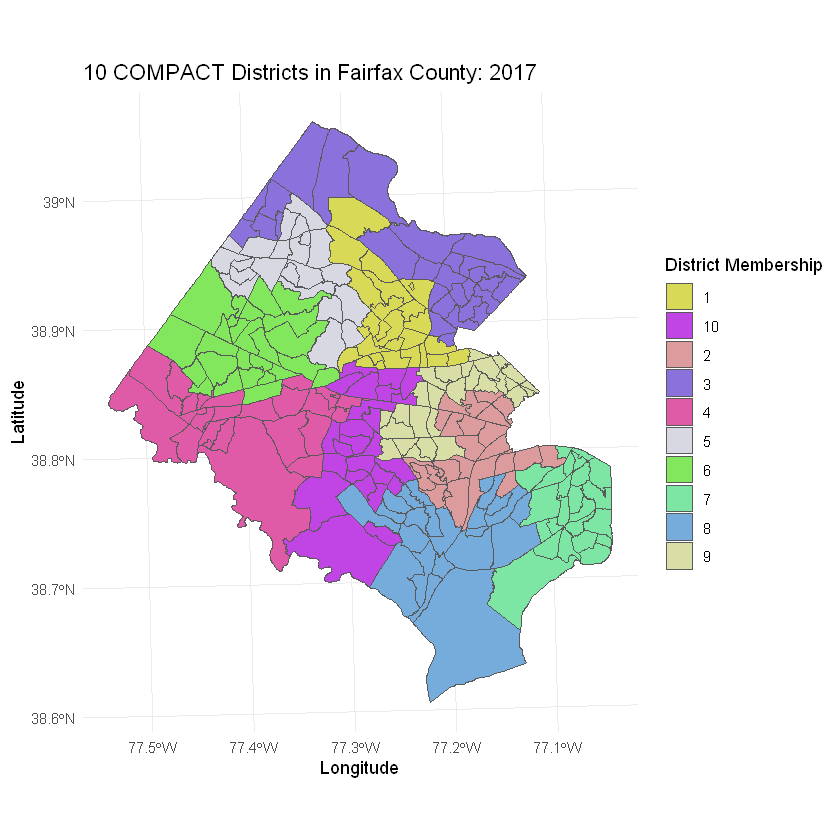

In [90]:
# Let's plot this!

cds_smc <- alg_smc$cdvec[,1]
plot_smc <- redist.map(shp=df_ff, 
        district_membership=cds_smc, 
        centroids=FALSE, 
        edges=FALSE,
        title="10 COMPACT Districts in Fairfax County: 2017") +
        theme(legend.position="right") +
        scale_fill_manual(values = colors)
        # geom_sf_label(aes(label = cds))
ggsave("fairfax_10_compact.png")
plot_smc

### 20% Population Constraint and Compactness Constraint

So that worked, but there are clearly some compactness problems going on here. 

I first need to calculate a `distancemat`, which is "a symmetric matrix with the squared distance between two precincts as its entries."

In [2]:
if (FALSE) {
    distances <- redist.distances(district_membership = cds,
                                  measure = "Hamming",
                                  ncores = 1)

    ## ----------------------------------------------------------
    ## Constrain on population and compactness with tempering,
    ## weight on population = 5.4 while weight on compactness = 3
    ## Also specifying argument for ssdmat, the distance matrix
    ## ----------------------------------------------------------
    mcmc.out.st.multiple <- redist.mcmc(adjobj = adjlist,
                                        popvec = precinct.data$pop,
                                        ndists = 10,
                                        nsims = 10000,
                                        constraint = c("population", "compact"),
                                        constraintweights = c(5.4, 3),
                                        ssdmat = ,
                                        temper = TRUE,
                                        betaweights = betaweights,
                                        maxiterrsg = 10000)
    mcmc.out.st <- redist.ipw(mcmc.out.st.multiple, targetpop = .2)
}